In [1]:
!pip install "burr[start]"
!pip install opentelemetry-instrumentation-openai


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.12 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.12 -m pip install --upgrade pip


# OpenTelemetry

In this notebook we'll instrument a simple Burr app with [OpenTelemetry](www.opentelemetry.io). See the [docs](https://burr.dagworks.io/concepts/additional-visibility/) for more information.

# Our application

Let's take a look at the graph we've defined in [application.py](./application.py). As you can see, it's a simple multi-modal chatbot.

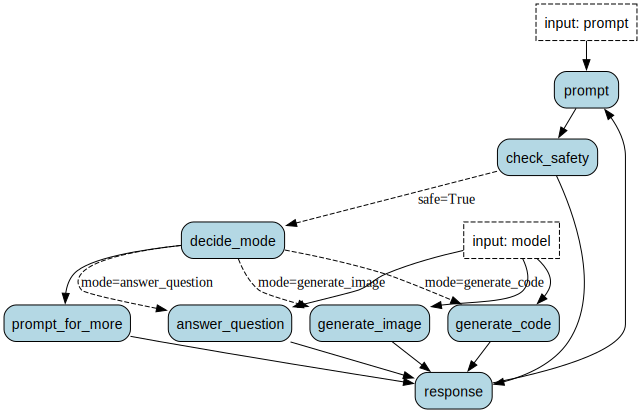

In [2]:
from application import graph
graph

# Building the application 

We're going to instrument this with OpenTelemetry -- first using Burr as the provider then using [Traceloop](traceloop.com). There are reasons to use them both, and you can use them together!

First, let's use Burr to build an application (vanilla) and run it:

In [3]:
from burr.core import ApplicationBuilder
app = (
    ApplicationBuilder()
    .with_entrypoint("prompt")
    .with_state(chat_history=[])
    .with_graph(graph)
    .build()
)
app.run(inputs={"prompt":"What is the capital of France?"}, halt_after=["response"])

(response: response, safe, mode -> chat_history,
 {'chat_item': {'content': 'The capital of France is Paris.',
   'type': 'text',
   'role': 'assistant'}},
 {'chat_history': [{'role': 'user', 'content': 'Please answer the following question:: What is the capital of France?', 'type': 'text'}, {'content': 'The capital of France is Paris.', 'type': 'text', 'role': 'assistant'}], '__SEQUENCE_ID': 4, 'prompt': 'What is the capital of France?', '__PRIOR_STEP': 'response', 'safe': True, 'mode': 'answer_question', 'response': {'content': 'The capital of France is Paris.', 'type': 'text', 'role': 'assistant'}})

# Instrumenting with OpenLLMetry

The [OpenLLMetry](https://github.com/traceloop/openllmetry) library provides a set of integrations that automatically instrument LLM libraries with OpenTelemetry.
In this case we'll be using the [OpenAI instrumentor](https://pypi.org/project/opentelemetry-instrumentation-openai/).

The following automatically instruments a set of attributes/spans for us:

In [4]:
from opentelemetry.instrumentation.openai import OpenAIInstrumentor
OpenAIInstrumentor().instrument()

# Tracking on Traceloop

To follow this you'll need an API key for traceloop -- you can sign up for the free 
tier at [traceloop.com](traceloop.com).

We can then build the application and track on traceloop. 

We:
1. Initialize traceloop
2. add the OpenTelemetryBridge hook to Burr -- this sets it up to capture Burr framework events as part of Open Telemetry

Note you can use any OpenTelemetry provider -- traceloop is specifically built for this, however, and has a variety of LLM-specific integrations.

Once you run this, visit [traceloop](app.traceloop.com) to see your traces!

In [8]:
# from traceloop.sdk import Traceloop
import os
from burr.integrations import opentelemetry
from burr.core import ApplicationBuilder

from traceloop.sdk import Traceloop

Traceloop.init(api_key=os.environ["TRACELOOP_API_KEY"])
               
app_otel = (
    ApplicationBuilder()
    .with_entrypoint("prompt")
    .with_state(chat_history=[])
    .with_graph(graph)
    .with_hooks(opentelemetry.OpenTelemetryBridge())
    .build()
)
app.run(inputs={"prompt":"What is the capital of France?"}, halt_after=["response"])

Traceloop syncing configuration and prompts
Traceloop exporting traces to https://api.traceloop.com authenticating with bearer token



(response: response, safe, mode -> chat_history,
 {'chat_item': {'content': 'The capital of France is Paris.',
   'type': 'text',
   'role': 'assistant'}},
 {'chat_history': [{'role': 'user', 'content': 'Please answer the following question:: What is the capital of France?', 'type': 'text'}, {'content': 'The capital of France is Paris.', 'type': 'text', 'role': 'assistant'}, {'role': 'user', 'content': 'Please answer the following question:: What is the capital of France?', 'type': 'text'}, {'content': 'The capital of France is Paris.', 'type': 'text', 'role': 'assistant'}, {'role': 'user', 'content': 'Please answer the following question:: What is the capital of France?', 'type': 'text'}, {'content': 'The capital of France is Paris.', 'type': 'text', 'role': 'assistant'}, {'role': 'user', 'content': 'Please answer the following question:: What is the capital of France?', 'type': 'text'}, {'content': 'The capital of France is Paris.', 'type': 'text', 'role': 'assistant'}], '__SEQUENCE_

# Tracking on Burr

You can also view on the Burr local tracker! This is good for local debugging and can go hand-in-hand with traceloop.

To do so, all you need to do is add the `use_otel_tracing=True` parameter to `with_tracker`.

In [12]:
app = (ApplicationBuilder()
        .with_entrypoint("prompt")
        .with_state(chat_history=[])
        .with_graph(graph)
        .with_tracker(
            project="demo_opentelemetry",
            use_otel_tracing=True)
        .build()
)

app.run(inputs={"prompt":"What is the capital of France?"}, halt_after=["response"])

(response: response, safe, mode -> chat_history,
 {'chat_item': {'content': 'The capital of France is Paris.',
   'type': 'text',
   'role': 'assistant'}},
 {'chat_history': [{'role': 'user', 'content': 'Please answer the following question:: What is the capital of France?', 'type': 'text'}, {'content': 'The capital of France is Paris.', 'type': 'text', 'role': 'assistant'}], '__SEQUENCE_ID': 4, 'prompt': 'What is the capital of France?', '__PRIOR_STEP': 'response', 'safe': True, 'mode': 'answer_question', 'response': {'content': 'The capital of France is Paris.', 'type': 'text', 'role': 'assistant'}})

# Viewing in UI

The following cell gives you a link to the prior run in the UI. If you have not yet, run `burr` in your terminal to start the local tracking server.

In [13]:
from IPython.display import Markdown
url = f"[Link to UI](http://localhost:7241/project/demo_tracing/null/{app.uid})"
Markdown(url)

[Link to UI](http://localhost:7241/project/demo_tracing/null/01492754-b899-410f-83c6-b5b86ef457c5)